In [42]:
!conda install numpy pillow pydicom -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.10
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [52]:
"""Parsing code for DICOMS and contour files"""

import pydicom
from pydicom.errors import InvalidDicomError

import numpy as np
from PIL import Image, ImageDraw


def parse_contour_file(filename):
    """Parse the given contour filename

    :param filename: filepath to the contourfile to parse
    :return: list of tuples holding x, y coordinates of the contour
    """

    coords_lst = []

    with open(filename, 'r') as infile:
        for line in infile:
            coords = line.strip().split()

            x_coord = float(coords[0])
            y_coord = float(coords[1])
            coords_lst.append((x_coord, y_coord))

    return coords_lst


def parse_dicom_file(filename):
    """Parse the given DICOM filename

    :param filename: filepath to the DICOM file to parse
    :return: dictionary with DICOM image data
    """

    try:
        dcm = pydicom.read_file(filename)
        dcm_image = dcm.pixel_array

        try:
            intercept = dcm.RescaleIntercept
        except AttributeError:
            intercept = 0.0
        try:
            slope = dcm.RescaleSlope
        except AttributeError:
            slope = 0.0

        if intercept != 0.0 and slope != 0.0:
            dcm_image = dcm_image*slope + intercept
        dcm_dict = {'pixel_data' : dcm_image}
        return dcm_dict
    except InvalidDicomError:
        return None


def poly_to_mask(polygon, width, height):
    """Convert polygon to mask

    :param polygon: list of pairs of x, y coords [(x1, y1), (x2, y2), ...]
     in units of pixels
    :param width: scalar image width
    :param height: scalar image height
    :return: Boolean mask of shape (height, width)
    """

    # http://stackoverflow.com/a/3732128/1410871
    img = Image.new(mode='L', size=(width, height), color=0)
    ImageDraw.Draw(img).polygon(xy=polygon, outline=0, fill=1)
    mask = np.array(img).astype(bool)
    return mask

In [53]:
i_contour = parse_contour_file('./final_data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0059-icontour-manual.txt')
print(i_contour)

[(130.5, 118.0), (131.0, 118.0), (131.5, 117.5), (132.0, 117.5), (132.5, 117.5), (133.0, 117.5), (133.5, 117.5), (134.0, 117.5), (134.5, 117.5), (135.0, 117.5), (135.5, 117.5), (136.0, 117.5), (136.5, 117.5), (137.0, 117.5), (137.5, 118.0), (138.0, 118.0), (138.5, 118.5), (139.0, 118.5), (139.5, 119.0), (140.0, 119.0), (140.5, 119.5), (141.0, 119.5), (141.5, 120.0), (142.0, 120.0), (142.5, 120.5), (143.0, 121.0), (143.5, 121.5), (144.0, 121.5), (144.5, 122.0), (145.0, 122.5), (145.5, 122.5), (146.0, 123.0), (146.5, 123.0), (147.0, 123.5), (147.5, 123.5), (148.0, 124.0), (148.5, 124.5), (149.0, 125.0), (149.5, 125.5), (150.0, 126.0), (150.0, 126.5), (150.0, 127.0), (150.5, 127.5), (150.5, 128.0), (151.0, 128.5), (151.0, 129.0), (151.0, 129.5), (151.0, 130.0), (151.0, 130.5), (151.5, 131.0), (151.5, 131.5), (151.5, 132.0), (151.5, 132.5), (151.5, 133.0), (152.0, 133.5), (152.0, 134.0), (152.0, 134.5), (152.0, 135.0), (152.0, 135.5), (152.0, 136.0), (152.5, 136.5), (152.5, 137.0), (152.5,

In [95]:
dicom_file = parse_dicom_file('final_data/dicoms/SCD0000101/3.dcm')
print(dicom_file)
print(dicom_file['pixel_data'].shape)


{'pixel_data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)}
(256, 256)


In [96]:
mask = poly_to_mask(i_contour, dicom_file['pixel_data'].shape[0], dicom_file['pixel_data'].shape[1])
print(mask)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


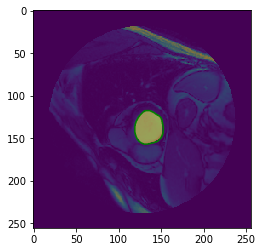

In [166]:
import matplotlib.pyplot as plt

# ds = pydicom.dcmread('final_data/dicoms/SCD0000101/120.dcm')
# print(ds)
# plt.imshow(ds.pixel_array)

ds = parse_dicom_file('final_data/dicoms/SCD0000101/60.dcm')

plt.imshow(ds['pixel_data'])


x = [point[0] for point in i_contour]
y = [point[1] for point in i_contour]
plt.plot(x, y, alpha=1, color='g')
plt.imshow(mask, alpha=0.5)

plt.savefig('temp.png')

# img = Image.new(mode='L', size=(100, 100), color=0)
# ImageDraw.Draw(img).polygon(xy=i_contour, outline=0, fill=1)
# plt.imshow(img)

In [62]:
def visualize_mask_overlay(img, mask):
    plt.clf()
    fig = plt.figure()
    plt.imshow(img)
#     for i, mask in enumerate(masks):
    plt.imshow(mask, alpha=0.5)


def visualize_contour_overlay(img, contours):
    plt.clf()
    fig = plt.figure()
    plt.imshow(img)
    for i, contour in enumerate(contours):
        x = [point[0] for point in contour]
        y = [point[1] for point in contour]
        plt.plot(x, y, alpha=1, color='g')


In [160]:
list_of_dicom_files = {}
set_of_dicom_files, set_of_dicom_indices = set(), set()
for (dirpath, dirnames, filenames) in os.walk('final_data/dicoms/SCD0000101'):
    for filename in filenames:
        if filename.endswith('.dcm') and filename[0] != '.':
            f = os.sep.join([dirpath, filename])
            list_of_dicom_files[filename] = f
            set_of_dicom_files.add(filename)
            set_of_dicom_indices.add(filename.split('.')[0])

list_of_dicom_files
set_of_dicom_files


{'1.dcm',
 '10.dcm',
 '100.dcm',
 '101.dcm',
 '102.dcm',
 '103.dcm',
 '104.dcm',
 '105.dcm',
 '106.dcm',
 '107.dcm',
 '108.dcm',
 '109.dcm',
 '11.dcm',
 '110.dcm',
 '111.dcm',
 '112.dcm',
 '113.dcm',
 '114.dcm',
 '115.dcm',
 '116.dcm',
 '117.dcm',
 '118.dcm',
 '119.dcm',
 '12.dcm',
 '120.dcm',
 '121.dcm',
 '122.dcm',
 '123.dcm',
 '124.dcm',
 '125.dcm',
 '126.dcm',
 '127.dcm',
 '128.dcm',
 '129.dcm',
 '13.dcm',
 '130.dcm',
 '131.dcm',
 '132.dcm',
 '133.dcm',
 '134.dcm',
 '135.dcm',
 '136.dcm',
 '137.dcm',
 '138.dcm',
 '139.dcm',
 '14.dcm',
 '140.dcm',
 '141.dcm',
 '142.dcm',
 '143.dcm',
 '144.dcm',
 '145.dcm',
 '146.dcm',
 '147.dcm',
 '148.dcm',
 '149.dcm',
 '15.dcm',
 '150.dcm',
 '151.dcm',
 '152.dcm',
 '153.dcm',
 '154.dcm',
 '155.dcm',
 '156.dcm',
 '157.dcm',
 '158.dcm',
 '159.dcm',
 '16.dcm',
 '160.dcm',
 '161.dcm',
 '162.dcm',
 '163.dcm',
 '164.dcm',
 '165.dcm',
 '166.dcm',
 '167.dcm',
 '168.dcm',
 '169.dcm',
 '17.dcm',
 '170.dcm',
 '171.dcm',
 '172.dcm',
 '173.dcm',
 '174.dcm',
 '

In [155]:
list_of_contour_files = {}
set_of_contour_files, set_of_contour_indices = set(), set()
for (dirpath, dirnames, filenames) in os.walk('final_data/contourfiles/SC-HF-I-1'):
    for filename in filenames:
        if filename.endswith('.txt') and filename[0] != '.': 
            f = os.sep.join([dirpath, filename])
            list_of_contour_files[filename] = f
            set_of_contour_files.add(f)
            set_of_contour_indices.add(filename)
            
list_of_contour_files
set_of_contour_files
set_of_contour_indices


{'IM-0001-0048-icontour-manual.txt',
 'IM-0001-0059-icontour-manual.txt',
 'IM-0001-0059-ocontour-manual.txt',
 'IM-0001-0068-icontour-manual.txt',
 'IM-0001-0079-icontour-manual.txt',
 'IM-0001-0079-ocontour-manual.txt',
 'IM-0001-0088-icontour-manual.txt',
 'IM-0001-0099-icontour-manual.txt',
 'IM-0001-0099-ocontour-manual.txt',
 'IM-0001-0108-icontour-manual.txt',
 'IM-0001-0119-icontour-manual.txt',
 'IM-0001-0119-ocontour-manual.txt',
 'IM-0001-0128-icontour-manual.txt',
 'IM-0001-0139-icontour-manual.txt',
 'IM-0001-0139-ocontour-manual.txt',
 'IM-0001-0148-icontour-manual.txt',
 'IM-0001-0159-icontour-manual.txt',
 'IM-0001-0159-ocontour-manual.txt',
 'IM-0001-0168-icontour-manual.txt',
 'IM-0001-0179-icontour-manual.txt',
 'IM-0001-0179-ocontour-manual.txt',
 'IM-0001-0188-icontour-manual.txt',
 'IM-0001-0199-icontour-manual.txt',
 'IM-0001-0199-ocontour-manual.txt',
 'IM-0001-0208-icontour-manual.txt',
 'IM-0001-0219-icontour-manual.txt',
 'IM-0001-0219-ocontour-manual.txt'}

In [153]:
def convert_contour_name_todicom_name(contour_name):
    dicom_number = int(contour_name.split('-')[2])
    return str(dicom_number) + '.dcm'

In [162]:
set_of_new_contour_names = set()

for contour_file in set_of_contour_indices:
    set_of_new_contour_names.add(convert_contour_name_todicom_name(contour_file))

set_of_new_contour_names


{'108.dcm',
 '119.dcm',
 '128.dcm',
 '139.dcm',
 '148.dcm',
 '159.dcm',
 '168.dcm',
 '179.dcm',
 '188.dcm',
 '199.dcm',
 '208.dcm',
 '219.dcm',
 '48.dcm',
 '59.dcm',
 '68.dcm',
 '79.dcm',
 '88.dcm',
 '99.dcm'}

In [165]:
set.intersection(set_of_dicom_files, set_of_new_contour_names)

{'108.dcm',
 '119.dcm',
 '128.dcm',
 '139.dcm',
 '148.dcm',
 '159.dcm',
 '168.dcm',
 '179.dcm',
 '188.dcm',
 '199.dcm',
 '208.dcm',
 '219.dcm',
 '48.dcm',
 '59.dcm',
 '68.dcm',
 '79.dcm',
 '88.dcm',
 '99.dcm'}